# Example Instrumental Variable Modelling (IV) with `pymc` models

This notebook shows an example of using instrumental variable regression. We will follow an example from Acemoglu, Johnson and Robinson (2001) which attempted to disentangle the effect of robust political institutions on economic productivity measured in GDP terms. 

In [23]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from patsy import build_design_matrices, dmatrices
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

import causalpy as cp
from causalpy.pymc_experiments import ExperimentalDesign, InstrumentalVariable
from causalpy.pymc_models import (
    InstrumentalVariableRegression,
    LinearRegression,
    ModelBuilder,
)

In [99]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'svg'
seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The idea of this work was to look at the different outcomes in `loggdp` terms for various colonised countries as a function of a measure of the robustness of political institutions `risk`. This latter variable is a score for the legal protection available against expropriation of property. The higher the score, the more legal protection available. The thought is that legal and political institutional structures have long-lasting benefits and since the colonies were treated differently under different colonial powers (with varying degree of institutional development), the argument is that we can potentially estimate the effects of political institution on GDP with this kind of data. 

In [21]:
iv_df = cp.load_data("risk")
iv_df

,longname,shortnam,logmort0,risk,loggdp,campaign,source0,slave,latitude,neoeuro,...,logmortjam,logmortcap250,logmortjam250,wandcafrica,malfal94,wacacontested,mortnaval2250,logmortnaval2250,mortnaval1250,logmortnaval1250
0,Angola,AGO,5.634790,5.36,7.77,1,0,0,0.1367,0,...,5.634790,5.521461,5.521461,1,0.95000,1,250.000000,5.521461,250.000000,5.521461
1,Argentina,ARG,4.232656,6.39,9.13,1,0,0,0.3778,0,...,4.034241,4.232656,4.034241,0,0.00000,0,30.500000,3.417727,15.070000,2.712706
2,Australia,AUS,2.145931,9.32,9.90,0,0,0,0.3000,1,...,2.145931,2.145931,2.145931,0,0.00000,0,8.550000,2.145931,8.550000,2.145931
3,Burkina Faso,BFA,5.634790,4.45,6.85,1,0,0,0.1444,0,...,5.634790,5.521461,5.521461,1,0.95000,1,250.000000,5.521461,250.000000,5.521461
4,Bangladesh,BGD,4.268438,5.14,6.88,1,1,0,0.2667,0,...,4.268438,4.268438,4.268438,0,0.12008,0,71.410004,4.268438,71.410004,4.268438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,USA,USA,2.708050,10.00,10.22,0,1,0,0.4222,1,...,2.708050,2.708050,2.708050,0,0.00000,0,15.000000,2.708050,15.000000,2.708050
60,Venezuela,VEN,4.357990,7.14,9.07,1,0,0,0.0889,0,...,4.130355,4.357990,4.130355,0,0.00704,0,93.250000,4.535284,NaN,NaN
61,Vietnam,VNM,4.941642,6.41,7.28,1,1,0,0.1778,0,...,4.941642,4.941642,4.941642,0,0.70110,0,140.000000,4.941642,140.000000,4.941642
62,South Africa,ZAF,2.740840,6.86,8.89,0,1,0,0.3222,0,...,2.740840,2.740840,2.740840,0,0.10450,0,15.500000,2.740840,15.500000,2.740840


The complication emerges when we observe that political institutions are **engodgenous** in the system which lead to that growth. So we need to control in some way for measurement error and bias we could expect if we fit a simple OLS model. They continue to argue that we can use an instrumental variable which is correlated with GDP only through the degree of political institutions by using instrumental variable regression. They suggesting using mortality rates faced by European settlers in the period as an instrument, because higher mortality rates will lead to less migration and investment in the error which should see a reduction in the political institutions established in the colonies. They could gather this data using military records. 

We can manually estimate the 2SLS estimate for the treatment effect of `risk` as follows: 

In [93]:
X = iv_df.risk.values.reshape(-1, 1)
Z = iv_df.logmort0.values.reshape(-1, 1)
t = iv_df.risk.values
y = iv_df.loggdp.values

simple_ols_reg = LinearRegression().fit(X, y)
first_stage_reg = LinearRegression().fit(Z, t)
fitted_risk_values = first_stage_reg.predict(Z)


second_stage_reg = LinearRegression().fit(X=fitted_risk_values.reshape(-1, 1), y=y)

print(
    "Simple OLS treatment Effect: Intercept and Beta Coeff",
    simple_ols_reg.intercept_,
    simple_ols_reg.coef_,
)
print(
    "First Stage Coefficient: Intercept and Beta Coeff",
    first_stage_reg.intercept_,
    first_stage_reg.coef_,
)
print(
    "Second Stage treatment Effect: Intercept and Beta Coeff",
    second_stage_reg.intercept_,
    second_stage_reg.coef_,
)

Simple OLS treatment Effect: Intercept and Beta Coeff 4.687414702305412 [0.51618698]
First Stage Coefficient: Intercept and Beta Coeff 9.365894904697788 [-0.61328925]
Second Stage treatment Effect: Intercept and Beta Coeff 1.9942956864448975 [0.92948966]


Note the significant differences between the naive OLS estimate `0.515` and the 2SLS estimate of `0.92`. This accords with the results reported in the paper.

In [100]:
sample_kwargs = {"tune": 1000, "draws": 2000, "chains": 2, "cores": 1}
instruments_formula = "risk  ~ 1 + logmort0"
formula = "loggdp ~  1 + risk"
instruments_data = iv_df[["risk", "logmort0"]]
data = iv_df[["loggdp", "risk"]]
# priors = {"mus": [[10, 0], [2, 0]], "sigmas": [[1, 1], [1, 1]]}
iv = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)


iv.model.idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 90 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [beta_t, beta_z, chol_cov, likelihood]
Sampling: [likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [101]:
az.summary(iv.model.idata, var_names=["beta_t", "beta_z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_t[Intercept],9.447,0.457,8.579,10.301,0.012,0.009,1411.0,1999.0,1.0
beta_t[logmort0],-0.631,0.095,-0.815,-0.456,0.003,0.002,1301.0,1927.0,1.0
beta_z[Intercept],2.237,0.652,1.044,3.429,0.021,0.015,927.0,1546.0,1.0
beta_z[risk],0.892,0.099,0.715,1.077,0.003,0.002,918.0,1462.0,1.0


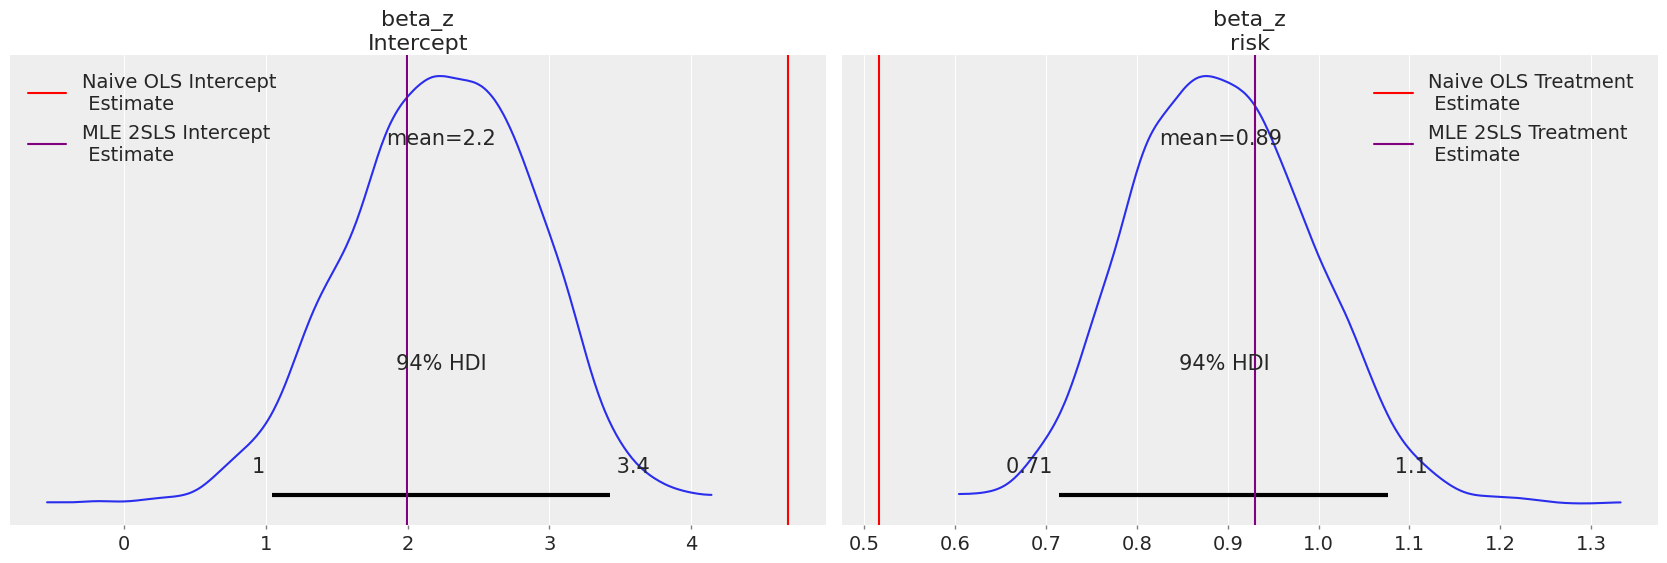

In [113]:
hdi_prob = 0.94
ax = az.plot_posterior(
    data=iv.model.idata,
    var_names=["beta_z"],
    hdi_prob=hdi_prob,
)

ax[0].axvline(
    iv.ols_beta_params[0], label="Naive OLS Intercept \n Estimate", color="red"
)
ax[1].axvline(
    iv.ols_beta_params[1], label="Naive OLS Treatment \n Estimate", color="red"
)
ax[0].axvline(
    iv.ols_beta_second_params[0], label="MLE 2SLS Intercept \n Estimate", color="purple"
)
ax[1].axvline(
    iv.ols_beta_second_params[1], label="MLE 2SLS Treatment \n Estimate", color="purple"
)
ax[0].legend()
ax[1].legend()